# Lab 1: Analys av Sakila-databasen
**Namn:** Rickard Garnau

**Datum:** 2025-12-21

## Introduktion
I denna laboration använder jag DuckDB för att utföra SQL-analyser på Sakila-databasen. Målet är att identifiera trender kring uthyrning, kunder och intäkter.

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

con = duckdb.connect("dashboard/sources/sakila.db")
con.execute("INSTALL sqlite; LOAD sqlite")


tables = ['actor', 'country', 'city', 'address', 'language', 'category',
          'customer', 'film', 'film_actor', 'film_category', 'film_text',
          'inventory', 'staff', 'store', 'payment', 'rental']

for table in tables:
    con.execute(f"CREATE OR REPLACE TABLE {table} AS SELECT * FROM sqlite_scan('data/sqlite-sakila.db', '{table}')")

print("Database loaded")


Database loaded


## Task 1: Utforskande SQL-analys
Här svarar vi på specifika affärsfrågor genom SQL-queries.

### 1. Filmer över 3 timmar
Vi vill identifiera vilka filmer som är extra långa (>180 min) då dessa kan vara svårare att schemalägga.

In [2]:
df_long_movies = con.sql("""
SELECT
    title,
    length as film_length
FROM
    film
WHERE
    length > 180
ORDER BY
    film_length DESC;
""").df().head()

df_long_movies

,title,film_length
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185


### 2. Sökning efter titlar med "LOVE"
Här letar vi efter filmer som har ordet 'LOVE' i titeln. Vi hanterar både exakta matchningar och där ordet förekommer i en mening.

In [14]:
df_love_in_title = con.sql("""
SELECT
    title,
    rating,
    length,
    description
FROM
    sakila.main.film
WHERE title = 'LOVE'
   OR title LIKE 'LOVE %'
   OR title LIKE '% LOVE'
   OR title LIKE '% LOVE %';
""").df()

display(df_love_in_title)

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


### 3. Statistik över filmlängder
En överblick av filmlängder i biblioteket.

In [4]:
df_stats_movies = con.sql("""
SELECT
    MIN(length) as min_length,
    AVG(length) as avg_length,
    MEDIAN (length) as median_length,
    MAX(length) as max_length
FROM
    sakila.main.film;
""").df()

df_stats_movies

,min_length,avg_length,median_length,max_length
0,46,115.272,114.0,185


### 4. Dyrast filmer att hyra per dag
Detta visar vilka filmer som är relativt sett dyrast för kunden att behålla en kort stund genom att dela hyreskostnaden med hyrestiden.

In [5]:
df_daily_cost = con.sql("""
SELECT
    title,
    rental_rate,
    rental_duration,
    (rental_rate / rental_duration) AS max_date_diff
FROM
    sakila.main.film
ORDER BY
    max_date_diff DESC
LIMIT
    10;
""").df()

df_daily_cost

,title,rental_rate,rental_duration,max_date_diff
0,ACE GOLDFINGER,4.99,3,1.663333
1,AMERICAN CIRCUS,4.99,3,1.663333
2,AUTUMN CROW,4.99,3,1.663333
3,BACKLASH UNDEFEATED,4.99,3,1.663333
4,BEAST HUNCHBACK,4.99,3,1.663333
5,BEHAVIOR RUNAWAY,4.99,3,1.663333
6,BILKO ANONYMOUS,4.99,3,1.663333
7,CARIBBEAN LIBERTY,4.99,3,1.663333
8,CASPER DRAGONFLY,4.99,3,1.663333
9,CASUALTIES ENCINO,4.99,3,1.663333


### 5. Mest produktiva skådespelare
Vilka skådespelare förekommer oftast i vårt sortiment? Dessa kan vara bra att använda i marknadsföringssyfte.

In [6]:
df_actor_num_movies = con.sql("""
SELECT
    a.first_name,
    a.last_name,
    COUNT(*) AS total_movies
FROM
    sakila.main.film f
    LEFT JOIN sakila.main.film_actor fa USING (film_id)
    LEFT JOIN sakila.main.actor a USING (actor_id)
GROUP BY
    a.first_name,
    a.last_name
ORDER BY
    total_movies DESC
LIMIT
    10;
""").df()

df_actor_num_movies

,first_name,last_name,total_movies
0,SUSAN,DAVIS,54
1,GINA,DEGENERES,42
2,WALTER,TORN,41
3,MARY,KEITEL,40
4,MATTHEW,CARREY,39
5,SANDRA,KILMER,37
6,SCARLETT,DAMON,36
7,HENRY,BERRY,35
8,ANGELA,WITHERSPOON,35
9,UMA,WOOD,35


### 6. Skådespelare nischade mot en genre
Här undersöker vi vilka skådespelare som gjort flest filmer inom en och samma genre.

In [7]:
df_genre_movies = con.sql("""
SELECT
    a.first_name,
    a.last_name,
    c.name AS genre,
    COUNT(*) AS total_movies
FROM
    sakila.main.actor a
    LEFT JOIN sakila.main.film_actor fa USING (actor_id)
    LEFT JOIN sakila.main.film_category fc USING (film_id)
    LEFT JOIN sakila.main.category c USING (category_id)
GROUP BY
    a.first_name,
    a.last_name,
    genre
ORDER BY
    total_movies DESC
LIMIT
    5;
""").df()

df_genre_movies

,first_name,last_name,genre,total_movies
0,BEN,WILLIS,Sports,9
1,JULIA,MCQUEEN,Horror,7
2,HUMPHREY,WILLIS,Foreign,7
3,GRACE,MOSTEL,Drama,7
4,SIDNEY,CROWE,New,7


### 7. Kunder per land
En analys av vår globala närvaro. Vilka länder har flest registrerade kunder? Detta är viktigt för att veta var vi bör fokusera vår expansion.

In [8]:
df_countries_customer = con.sql("""
SELECT
    co.country,
    COUNT(customer_id) AS total_customers
FROM
    sakila.main.customer c
    LEFT JOIN sakila.main.address USING (address_id)
    LEFT JOIN sakila.main.city ci USING (city_id)
    LEFT JOIN sakila.main.country co USING (country_id)
GROUP BY
    co.country
ORDER BY
    total_customers DESC
LIMIT
    5;

""").df()

df_countries_customer

,country,total_customers
0,India,60
1,China,53
2,United States,36
3,Japan,31
4,Mexico,30


### 8. Intäkter baserat på åldersgräns (Rating)
Vilken målgrupp genererar mest pengar? Vi summerar totala intäkter för varje film-rating (G, PG, R, etc).

In [9]:
df_rating_movies = con.sql("""
SELECT
    f.rating,
    SUM(amount) as total_sales
FROM
    sakila.main.film f
    LEFT JOIN sakila.main.inventory i USING (film_id)
    LEFT JOIN sakila.main.rental r USING (inventory_id)
    LEFT JOIN sakila.main.payment p USING (rental_id)
GROUP BY
    f.rating
ORDER BY
    total_sales DESC;
""").df()

df_rating_movies

,rating,total_sales
0,PG-13,15259.16
1,NC-17,13875.07
2,PG,13337.91
3,R,13270.19
4,G,11664.23


### 9. Månadens anställd (Bäst säljare)
Vi rankar personalen baserat på totalt försäljningsbelopp för att se vem som presterar bäst.

In [10]:
df_employee_month = con.sql("""
SELECT
    s.staff_id,
    s.first_name,
    s.last_name,
    SUM(amount) as total_sales
FROM
    sakila.main.staff s
    LEFT JOIN sakila.main.payment p USING (staff_id)
GROUP BY
    s.staff_id,
    s.first_name,
    s.last_name
ORDER BY
    total_sales DESC;

""").df()

df_employee_month

,staff_id,first_name,last_name,total_sales
0,2,Jon,Stephens,33927.04
1,1,Mike,Hillyer,33489.47


### 10. Faktisk hyrestid (Genomsnitt)
Vilka filmer behåller kunderna längst tid hemma? Här räknar vi ut skillnaden mellan uthyrningsdatum och returdatum.
- Notera: En lång hyrestid kan tyda på att filmen är uppskattad, eller att den är lång och svår att hinna se klart.

In [11]:
df_longest_rent = con.sql("""
SELECT
    f.title,
    AVG(return_date - rental_date) as top_movie
FROM
    sakila.main.film f
    LEFT JOIN sakila.main.inventory i USING (film_id)
    LEFT JOIN sakila.main.rental r USING (inventory_id)
WHERE
    r.return_date IS NOT NULL
GROUP BY
    f.title
ORDER BY
    top_movie DESC
LIMIT
    10;
""").df()

df_longest_rent

,title,top_movie
0,FLIGHT LIES,7 days 06:29:55
1,IMPACT ALADDIN,7 days 04:48:53.333336
2,AFRICAN EGG,7 days 02:33:32.727276
3,HARDLY ROBBERS,6 days 22:45:45
4,MADRE GABLES,6 days 19:29:00.000005
5,HUNTER ALTER,6 days 19:26:00
6,NOTORIOUS REUNION,6 days 18:14:17.142862
7,WAGON JAWS,6 days 17:55:54
8,MOTHER OLEANDER,6 days 17:33:34.285716
9,REDS POCUS,6 days 17:08:20


## Task 2: Visualisering
Här visualiserar vi insikterna för att lättare se trender.

### Topp 5 kunder baserat på spendering
Vilka är våra VIP-kunder?

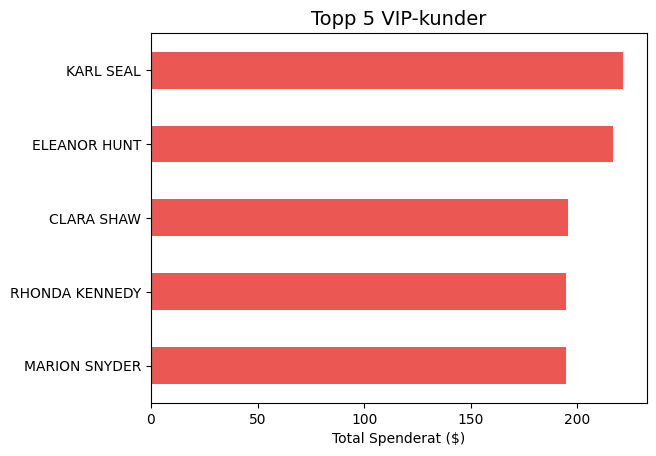

In [12]:
df_big_spenders = con.sql("""
SELECT
    c.first_name || ' ' || c.last_name as full_name,
    SUM(p.amount) as total_spent
FROM
    customer c
    LEFT JOIN payment p USING (customer_id)
GROUP BY
    full_name
ORDER BY
    total_spent DESC
LIMIT 5;
""").df()

ax = df_big_spenders.plot(
    kind="barh", 
    x="full_name", 
    y="total_spent", 
    color="#eb5752", 
    legend=False
)

ax.set_title("Topp 5 VIP-kunder", fontsize=14)
ax.set_xlabel("Total Spenderat ($)")
ax.set_ylabel("")
ax.invert_yaxis()

plt.show();



### Intäkter per filmkategori
Vilka genrer är mest lönsamma? Genom att summera alla betalningar kopplade till uthyrningar inom varje kategori får vi en tydlig bild av vad kunderna föredrar att betala för.

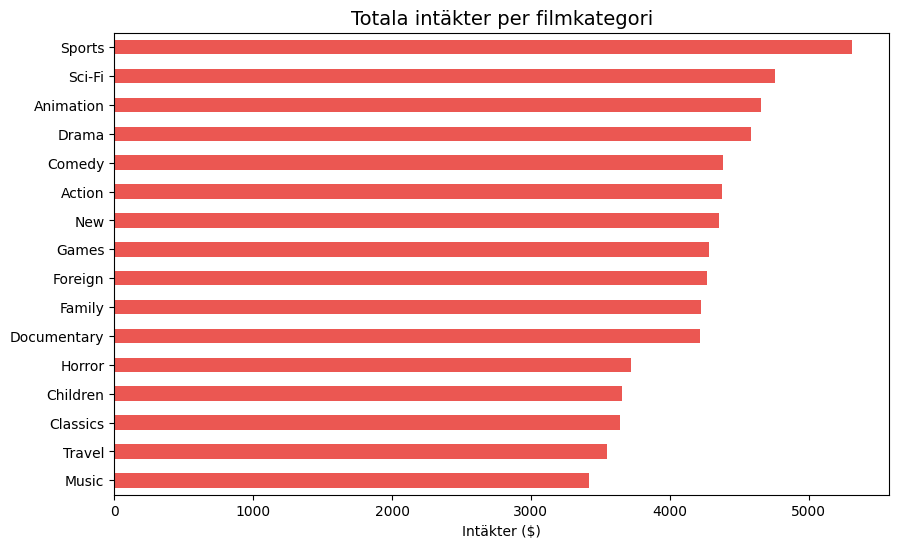

In [13]:
df_revenue_per_film_category = con.sql("""
SELECT
    c.name as genre,
    SUM(p.amount) as total_revenue
FROM
    category c
    JOIN film_category fc USING (category_id)
    JOIN film f USING (film_id)
    JOIN inventory i USING (film_id)
    JOIN rental r USING (inventory_id)
    JOIN payment p USING (rental_id)
GROUP BY
    genre
ORDER BY
    total_revenue DESC;
""").df()

ax = df_revenue_per_film_category.plot(
    kind="barh", 
    x="genre", 
    y="total_revenue", 
    color="#eb5752",
    legend=False,
    figsize=(10, 6)
)

ax.set_title("Totala intäkter per filmkategori", fontsize=14)
ax.set_xlabel("Intäkter ($)")
ax.set_ylabel("")
ax.invert_yaxis()

plt.show();